## Setup

#### Install Dependencies

In [1]:
#!pip install labelme albumentations

In [2]:
# !pip install tensorflow-gpu tensorflow matplotlib opencv-python

In [3]:
#!pip install tensorflow matplotlib opencv-python

#### Collect Images with Opencv

In [4]:
import os
import time
import uuid # allows to create unique filenames automatically uuid.uuid1()
import cv2

In [5]:
IMAGES_PATH = os.path.join('data', 'images')
images_no = 30

In [6]:
# cap = cv2.VideoCapture(0) # Connecting to Video camera
# for imgnum in range(images_no):
#     print('Collecting image {}'.format(imgnum))
    
#     # Read a frame from the capture device
#     ret, frame = cap.read() # read from device used to  capture
    
#     # Check if the frame is empty
#     if not ret:
#         print("Error: Failed to capture frame.")
#         break
    
#     # Generate a unique filename for the image using UUID
#     imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    
    
#     cv2.imwrite(imgname, frame)
#     cv2.imshow('frame', frame)
    
#     # Pause for 0.5 seconds before capturing the next image
#     time.sleep(0.5)
    
#     # Check if the 'q' key is pressed, and break the loop if true
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # Release the video capture device
# cap.release()

# # Close all OpenCV windows
# cv2.destroyAllWindows()

cv2.imwrite(imgname, frame):
This line uses the imwrite function from the OpenCV library.
It saves the captured frame (frame) as an image file with the specified filename (imgname). The image format is determined by the file extension in imgname (e.g., '.jpg').

cv2.imshow('frame', frame):
This line uses the imshow function from OpenCV for displaying images.
It displays the captured frame (frame) in a window named 'frame'. This is optional and mainly used for real-time visualization during the image capturing process.

#### Annotate Images with LabelMe

In [7]:
# !labelme

In [8]:
import tensorflow as tf
import json # Work with json files for label
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# List all the GPU devices on my machine
gpus = tf.config.experimental.list_physical_devices('GPU')

In [10]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
# Limiting the memory and telling the GPUs not to use up all the memory
# The GPUs can only use what they need

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [11]:
# Find out if GPU is availaable
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [12]:
tf.config.list_physical_devices('GPU')

[]

#### Load Image into Tensorflow Pipeline

In [13]:
# Load images as tensorflow pipeline
# images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [14]:
# Take one image from the dataset, then next image, then next
# This basically returns the file path to the image, to return the image itself as numpy array, we use the function load image down
# images.as_numpy_iterator().next()

In [15]:
# from FaceDetection import load_image

In [16]:
# images = images.map(load_image)

images.as_numpy_iterator().next()

In [17]:
# This time loading the images in batches of 4
# image_generator = images.batch(4).as_numpy_iterator()

In [18]:
# Plot the images 
# plot_images = image_generator.next()

In [19]:
# fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# for idx, image in enumerate(plot_images):
#     ax[idx].imshow(image) 
# plt.show()

## Partition Unaugmented Data

 - Manually split data into train, test, validation set
    - create respective folders in the data directory
    - inside the ```train```, ```test```, ```val```, folders create ```images``` and ```labels``` folder
    - Move images into the folders in this project (63 to train, 14 to test, 13 to val)

#### Move Matching Labels

In [20]:
# for folder in ['train','test','val']:
#     for file in os.listdir(os.path.join('data', folder, 'images')):
        
#         filename = file.split('.')[0]+'.json'
#         existing_filepath = os.path.join('data','labels', filename)
#         if os.path.exists(existing_filepath): 
#             new_filepath = os.path.join('data',folder,'labels',filename)
#             os.replace(existing_filepath, new_filepath)

## Augment Images and Labels with Albumentations

In [21]:
# !pip install albumentations
import albumentations as alb

In [22]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

- Check the [Formats](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation) of the boundary box parameters. 
- In this notebook, I am using ```albumentations format```
- This is by dividing the ```pascal_voc``` which is the default format by the width and height of the image

#### Load a Test Image and Annotation with OpenCV and JSON

In [23]:
img = cv2.imread(os.path.join('data','train', 'images','2ae8ff7e-d3be-11ee-a616-acfdce6b3a54.jpg'))

In [24]:
with open(os.path.join('data', 'train', 'labels', '2ae8ff7e-d3be-11ee-a616-acfdce6b3a54.json'), 'r') as f:
    label = json.load(f)

In [25]:
label['shapes'][0]

{'label': 'face',
 'points': [[233.46153846153842, 229.01098901098902],
  [372.4725274725274, 378.46153846153845]],
 'group_id': None,
 'description': '',
 'shape_type': 'rectangle',
 'flags': {},
 'mask': None}

- Points indicate the coordinates of (top left and bottom right) and (top rigth and botto left) as done in labelme labelling
- Basically saying (x,y), (x,y) or (width, height), (width, height)

#### Extract Coordinates and Rescale to Match Image Resolution

In [26]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [27]:
coords

[233.46153846153842, 229.01098901098902, 372.4725274725274, 378.46153846153845]

In [28]:
img.shape

(480, 640, 3)

In [29]:
# Divide the image coordinates by width and height
coords = list(np.divide(coords, [640,480,640,480]))

In [30]:
coords

[0.3647836538461538,
 0.47710622710622713,
 0.5819883241758241,
 0.7884615384615384]

#### Apply Augmentations and View Results

In [31]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [32]:
augmented['bboxes'][0][2:]

(0.8034188034188035, 0.5488644688644688)

In [33]:
augmented['bboxes']

[(0.49450549450549464,
  0.21675213675213678,
  0.8034188034188035,
  0.5488644688644688)]

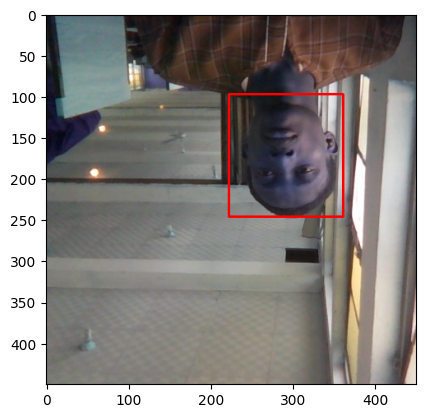

In [34]:
# cv2.rectangle draws a rectangle around the labelled image as a bounding box
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

### Build and Run Augmentation Pipeline

 - Manually create ```aug_data``` 
    - create respective folders in the data directory
    - inside the ```train```, ```test```, ```val```, folders create ```images``` and ```labels``` folder
    - We are going to augment all the data in the ```data``` directory and put them in their respective directories

#### Run Augmentation Pipeline

In [ ]:
# iterate into the data directory train, test and val
for partition in ['train','test','val']:
    # Read each image in each directory
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)